In [25]:
import os
import joblib

from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN
import torch
from pathlib import Path
from facenet_pytorch import InceptionResnetV1
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score


In [3]:
data_dir = Path("students")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mtcnn = MTCNN(keep_all=True, device=device, min_face_size=40, thresholds=[0.8, 0.9, 0.9])

In [5]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.Resize((160, 160)),  # Resize images to 160x160 for FaceNet
    transforms.ToTensor()
])

In [6]:
augmented_data = []
labels = []

In [7]:
from itertools import chain
for student_dir in data_dir.iterdir():
    if student_dir.is_dir():
        # Process all supported formats: .jpg, .jpeg, .png
        for image_path in chain(student_dir.glob("*.jpg"), student_dir.glob("*.jpeg"), student_dir.glob("*.png")):
            image = Image.open(image_path)
            boxes, _ = mtcnn.detect(image)
            
            if boxes is not None:
                for box in boxes:
                    face = image.crop(box)  # Crop the detected face
                    augmented_image = augmentation(face)  # Augment the face image
                    augmented_data.append(augmented_image)
                    labels.append(student_dir.name)  # Label is the student name


In [8]:
facenet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [9]:
embeddings = []
with torch.no_grad():
    for img in augmented_data:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        embedding = facenet_model(img)
        embeddings.append(embedding.squeeze().cpu().numpy())  # Squeeze to remove batch dim

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [11]:
embeddings_array = np.array(embeddings)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)

In [13]:
classifier = SVC(kernel='rbf', probability=True, class_weight='balanced')
classifier.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [14]:
calibrated_classifier = CalibratedClassifierCV(classifier, cv='prefit')
calibrated_classifier.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=SVC(class_weight='balanced', probability=True))

In [15]:
accuracy = calibrated_classifier.score(X_test, y_test)
print(f"SVM Classifier Test Accuracy: {accuracy * 100:.2f}%")

SVM Classifier Test Accuracy: 92.86%


In [16]:
y_pred = calibrated_classifier.predict(X_test)

In [17]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
                     precision    recall  f1-score   support

    Abhishek Rokka       1.00      1.00      1.00         2
    Basanta Gurung       0.67      1.00      0.80         2
      Nikesh Bista       1.00      1.00      1.00         2
    Pukar Bhandari       1.00      1.00      1.00         1
     Saugat Balami       1.00      0.50      0.67         2
  Subarna Shrestha       1.00      1.00      1.00         2
Sudarshan Bhandari       1.00      1.00      1.00         2
      Tilak Tamang       1.00      1.00      1.00         1

          accuracy                           0.93        14
         macro avg       0.96      0.94      0.93        14
      weighted avg       0.95      0.93      0.92        14



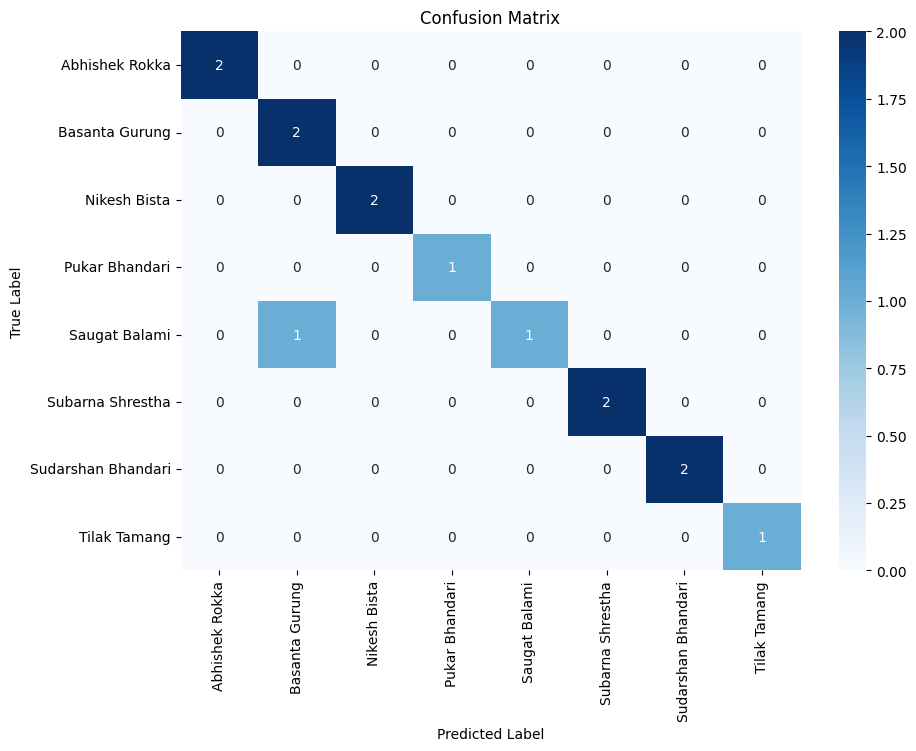

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [19]:
skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(classifier, embeddings_array, encoded_labels, cv=skf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%')


Cross-Validation Accuracy Scores: [1.         0.92857143 1.         1.         0.92307692]
Mean Cross-Validation Accuracy: 97.03%


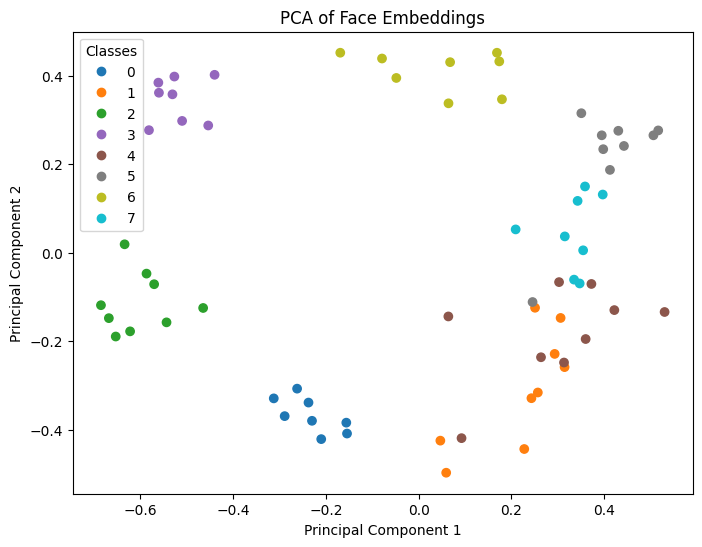

In [20]:
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings_array)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_pca[:, 0], reduced_embeddings_pca[:, 1], c=encoded_labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA of Face Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

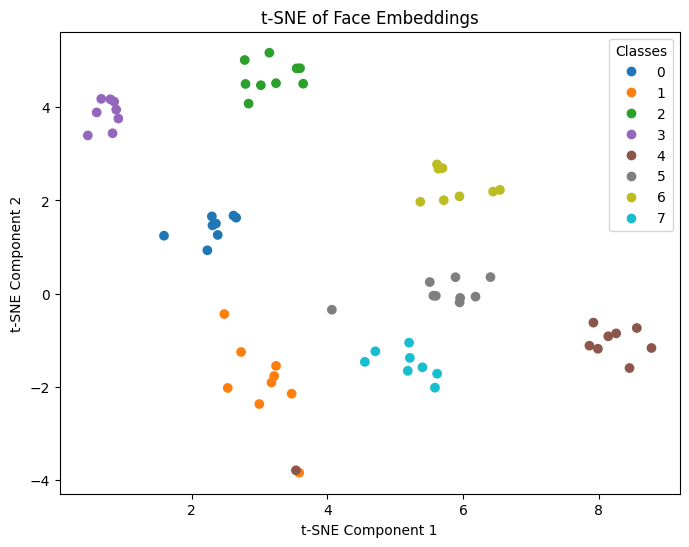

In [21]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embeddings_array)

# Plot the t-SNE reduced embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=encoded_labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of Face Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Number of faces detected: 5
Face 1 predicted class: Basanta Gurung with confidence: 0.69
Face 2 predicted class: Nikesh Bista with confidence: 0.70
Face 3 predicted class: Saugat Balami with confidence: 0.77
Face 4 predicted class: Pukar Bhandari with confidence: 0.61
Face 5 predicted class: Abhishek Rokka with confidence: 0.68


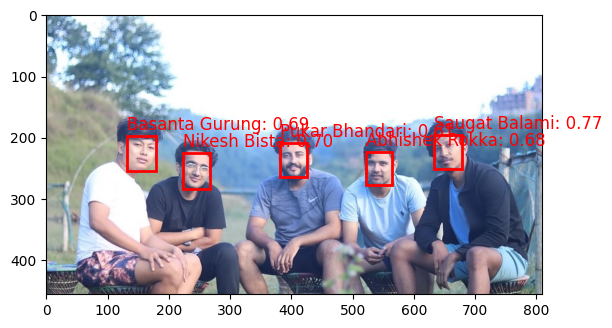

In [22]:
from PIL import Image
import matplotlib.patches as patches

def predict_and_display(image_path, mtcnn, facenet_model, calibrated_classifier, label_encoder):
    # Load the image
    image = Image.open(image_path)
    
    # Detect faces in the image
    boxes, _ = mtcnn.detect(image)
    
    if boxes is not None:
        print(f"Number of faces detected: {len(boxes)}")
        
        # Plot the image with bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        
        for i, box in enumerate(boxes):
            # Crop the face from the image
            face = image.crop(box)
            face = augmentation(face).unsqueeze(0).to(device)  # Apply same preprocessing
            
            # Extract face embedding using the pre-trained FaceNet model
            with torch.no_grad():
                embedding = facenet_model(face)
            embedding = embedding.squeeze().cpu().numpy()
            
            # Predict the class using the calibrated SVM classifier
            pred_label = calibrated_classifier.predict([embedding])
            pred_proba = calibrated_classifier.predict_proba([embedding])
            
            # Get the predicted class and confidence score
            pred_class = label_encoder.inverse_transform(pred_label)
            pred_proba_value = pred_proba.max()
            
            # Check confidence and display appropriate result
            if pred_proba_value >= 0.60:
                print(f"Face {i+1} predicted class: {pred_class[0]} with confidence: {pred_proba_value:.2f}")
                label_to_display = f"{pred_class[0]}: {pred_proba_value:.2f}"
            else:
                print(f"Face {i+1} is predicted as 'Unknown' (confidence: {pred_proba_value:.2f})")
                label_to_display = "Unknown"
            
            # Draw bounding box and label on the image
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1] - 10, label_to_display, color='red', fontsize=12)
        
        plt.show()
    else:
        print("No face detected in the image.")

# Predict and display the result for a new image
image_path = "TestImages/test image 3.jpg"
predict_and_display(image_path, mtcnn, facenet_model, calibrated_classifier, label_encoder)


In [23]:
image_path = "TestImages/salman khan.webp"
predict_and_display(image_path, mtcnn, facenet_model, calibrated_classifier, label_encoder)

FileNotFoundError: [Errno 2] No such file or directory: 'TestImages/salman khan.webp'

In [ ]:
from PIL import Image
import matplotlib.patches as patches

def predict_and_display_multiple(images_paths, mtcnn, facenet_model, calibrated_classifier, label_encoder):
    for image_path in images_paths:
        print(f"Processing image: {image_path}")
        
        # Load the image
        image = Image.open(image_path)
        
        # Detect faces in the image
        boxes, _ = mtcnn.detect(image)
        
        if boxes is not None:
            print(f"Number of faces detected: {len(boxes)}")
            
            # Plot the image with bounding boxes
            fig, ax = plt.subplots(1)
            ax.imshow(image)
            
            for i, box in enumerate(boxes):
                # Crop the face from the image
                face = image.crop(box)
                face = augmentation(face).unsqueeze(0).to(device)  # Apply same preprocessing
                
                # Extract face embedding using the pre-trained FaceNet model
                with torch.no_grad():
                    embedding = facenet_model(face)
                embedding = embedding.squeeze().cpu().numpy()
                
                # Predict the class using the calibrated SVM classifier
                pred_label = calibrated_classifier.predict([embedding])
                pred_proba = calibrated_classifier.predict_proba([embedding])
                
                # Get the predicted class and confidence score
                pred_class = label_encoder.inverse_transform(pred_label)
                pred_proba_value = pred_proba.max()
                
                # Check confidence and display appropriate result
                if pred_proba_value >= 0.60:
                    print(f"Face {i+1} predicted class: {pred_class[0]} with confidence: {pred_proba_value:.2f}")
                    label_to_display = f"{pred_class[0]}: {pred_proba_value:.2f}"
                else:
                    print(f"Face {i+1} is predicted as 'Unknown' (confidence: {pred_proba_value:.2f})")
                    label_to_display = "Unknown"
                
                # Draw bounding box and label on the image
                rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, label_to_display, color='red', fontsize=12)
            
            plt.show()
        else:
            print("No face detected in the image.")

# Define an array of image paths

images_paths = [
    "TestImages/test image 1.jpg", 
    "TestImages/test image 2.jpg", 
    "TestImages/test image 3.jpg",
    "TestImages/test image 4.jpg",
    "TestImages/test image 5.jpg",
    "TestImages/test image 6.jpg",
    "TestImages/test image 7.jpg",
    "TestImages/test image 8.jpg",
    "TestImages/test image 9.jpg",
    "TestImages/test image 10.webp"
]
# Predict and display the results for the array of photos
predict_and_display_multiple(images_paths, mtcnn, facenet_model, calibrated_classifier, label_encoder)


In [23]:

# Assuming svm_model is the trained SVM model
model_filename = 'svm_model.pkl'

# Save the trained model to a file
joblib.dump(calibrated_classifier, model_filename)
joblib.dump(label_encoder, 'label_encoder.pkl')

print(f"Model saved to {model_filename}")


Model saved to svm_model.pkl


In [26]:
joblib.dump(embeddings, 'embeddings.pkl')
joblib.dump(labels, 'labels.pkl')

['labels.pkl']